<a href="https://colab.research.google.com/github/demircanserdar/CS412/blob/main/models/LogisticRegression%26RUSBoostClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Text Processing

In [ ]:
import regex
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np

nltk.download('stopwords')
nltk.download('wordnet')

wordnet_lemmatizer = WordNetLemmatizer()
stop = stopwords.words('english')

def filter_text(text, stop_words):
    word_tokens = WordPunctTokenizer().tokenize(text.lower())
    filtered_text = [regex.sub('[^a-z ]+', '', w) for w in word_tokens]
    filtered_text = [regex.sub('[ ][ ]+', '', w) for w in filtered_text]
    filtered_text = [regex.sub('[0-9]', '', w) for w in filtered_text]
    filtered_text = [wordnet_lemmatizer.lemmatize(w, 'v') for w in filtered_text if not w in stop_words and len(w) > 2 and len(w) < 50]
    return " ".join(filtered_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Train Test Split

In [ ]:
df = pd.read_csv("preprocessed_text.csv")
df = df.dropna()

In [ ]:
df.head()

,Unnamed: 0,bug id,summary,severity,filtered_text,classification
0,0,365569,Remove workaround from bug 297227,normal,remove workaround bug,3
1,1,365578,Print Preview crashes on any URL in gtk2 builds,critical,print preview crash url gtk build,6
2,2,365582,Lines are not showing in table,major,line show table,4
3,3,365584,Firefox render ÛÏsimplified ArabicÛ font fa...,normal,firefox render simplify arabic font face incor...,3
4,4,365597,Crash [@ nsINodeInfo::NodeInfoManager],critical,crash nsinodeinfo nodeinfomanager,6


In [ ]:
temp_df, test_df = train_test_split(df, test_size=0.3, random_state = 42, stratify = df['classification'])
train_df, val_df = train_test_split(temp_df, test_size=0.2, random_state = 42, stratify = temp_df['classification'])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words = 'english',  min_df = 2, max_features = 20000, use_idf = True)
x_train = tfidf.fit_transform(train_df['filtered_text'])
x_val = tfidf.transform(val_df['filtered_text'])
y_train = train_df['classification']
y_val = val_df['classification']

x_test = tfidf.transform(test_df['filtered_text'])
y_test = test_df['classification']

In [ ]:
pred_df = pd.read_csv("bugs-test.csv")
pred_df['filtered_text'] = pred_df["summary"].apply(lambda x : filter_text(x, stop))

val_vec = tfidf.fit_transform(df['filtered_text'])
test_vec = tfidf.transform(pred_df['filtered_text'])

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.44      0.02      0.03       620
           2       1.00      0.01      0.02       434
           3       0.87      0.98      0.92     17617
           4       0.65      0.04      0.08       848
           5       0.00      0.00      0.00        98
           6       0.79      0.71      0.74      2612

    accuracy                           0.86     22229
   macro avg       0.62      0.29      0.30     22229
weighted avg       0.84      0.86      0.82     22229



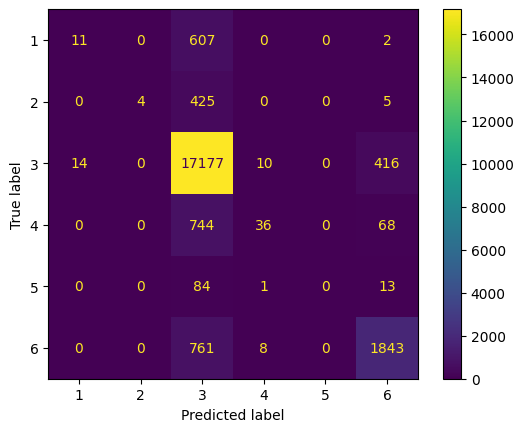

In [ ]:
model_lr = LogisticRegression(max_iter = 500).fit(x_train, y_train)
predicted = model_lr.predict(x_val)
print(classification_report(y_val, predicted))
cm = confusion_matrix(y_val, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_lr.classes_)
disp.plot()
plt.show()

              precision    recall  f1-score   support

           1       0.37      0.01      0.02      1328
           2       0.71      0.01      0.03       931
           3       0.87      0.97      0.92     37752
           4       0.64      0.04      0.07      1816
           5       0.50      0.00      0.01       210
           6       0.78      0.71      0.74      5597

    accuracy                           0.86     47634
   macro avg       0.64      0.29      0.30     47634
weighted avg       0.83      0.86      0.82     47634



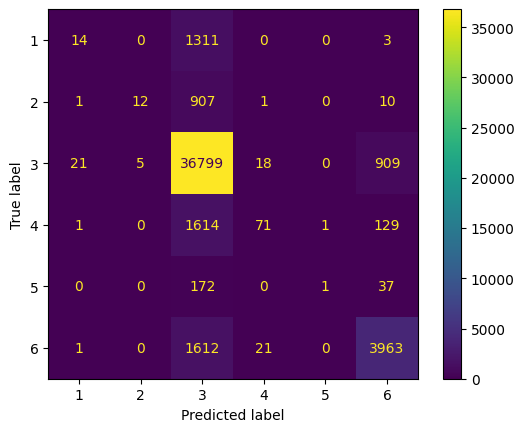

In [ ]:
predicted = model_lr.predict(x_test)
print(classification_report(y_test, predicted))
cm = confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_lr.classes_)
disp.plot()
plt.show()

In [ ]:
model_lr.fit(val_vec, df['classification'])

LogisticRegression(max_iter=500)

In [ ]:
predicted = model_lr.predict(test_vec)

In [ ]:
rm = {1: "enhancement",
     2: "minor",
     3: "normal",
     4: "major",
     5: "blocker",
     6: "critical"}

In [ ]:
pred_df["pred"] = predicted
res_df = pred_df[["bug id", "pred"]]
res_df = res_df.rename(columns={'bug id': 'bug_id'})
res_df["severity"] = res_df["pred"].apply(lambda x: rm[x])
res = res_df[["bug_id","severity"]]
res.set_index("bug_id", inplace=True)
print(np.unique(predicted, return_inverse=True, return_counts=True))

(array([1, 3, 4, 5, 6]), array([1, 1, 1, ..., 4, 4, 1]), array([   60, 78828,   105,     8,  7093]))


In [ ]:
res.head()

,severity
bug_id,
1143402,normal
1143405,normal
1143409,normal
1143411,normal
1143417,normal


In [ ]:
res.to_csv("logistic_regression_prediction.csv")

# RUSBoostClassifier

In [ ]:
from imblearn.ensemble import RUSBoostClassifier
from sklearn.tree import DecisionTreeClassifier

clf = RUSBoostClassifier(estimator = DecisionTreeClassifier(max_features=20), n_estimators=200, algorithm='SAMME.R', sampling_strategy = 'not majority',
                              random_state=0)
clf.fit(x_train, y_train)

RUSBoostClassifier(estimator=DecisionTreeClassifier(max_features=20),
                   n_estimators=200, random_state=0,
                   sampling_strategy='not majority')

              precision    recall  f1-score   support

           1       1.00      0.01      0.01       620
           2       1.00      0.00      0.01       434
           3       0.79      1.00      0.89     17617
           4       0.95      0.02      0.04       848
           5       0.27      0.03      0.06        98
           6       1.00      0.00      0.00      2612

    accuracy                           0.79     22229
   macro avg       0.84      0.18      0.17     22229
weighted avg       0.83      0.79      0.70     22229



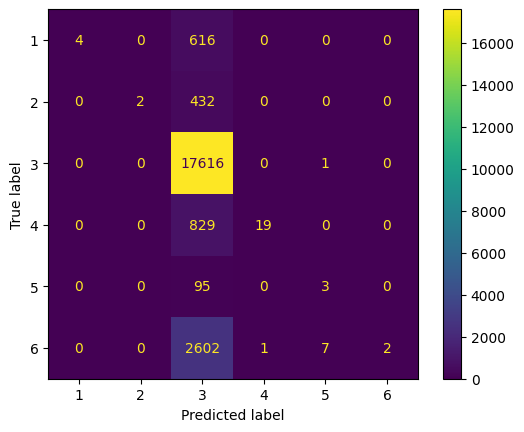

              precision    recall  f1-score   support

           1       1.00      0.00      0.01      1328
           2       1.00      0.01      0.01       931
           3       0.79      1.00      0.89     37752
           4       0.97      0.02      0.04      1816
           5       0.19      0.02      0.04       210
           6       0.83      0.00      0.00      5597

    accuracy                           0.79     47634
   macro avg       0.80      0.18      0.16     47634
weighted avg       0.81      0.79      0.70     47634



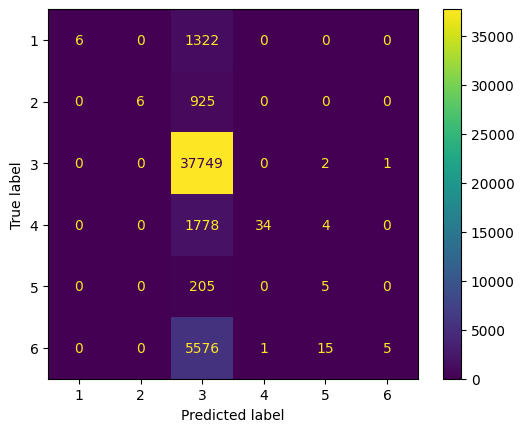

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predicted = clf.predict(x_val)
print(classification_report(y_val, predicted))


cm = confusion_matrix(y_val, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

predicted = clf.predict(x_test)
print(classification_report(y_test, predicted))

cm = confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
clf.fit(val_vec, df['classification'])

RUSBoostClassifier(estimator=DecisionTreeClassifier(max_features=20),
                   n_estimators=200, random_state=0,
                   sampling_strategy='not majority')

In [ ]:
predicted = clf.predict(test_vec)

pred_df["pred"] = predicted
res_df = pred_df[["bug id", "pred"]]
res_df = res_df.rename(columns={'bug id': 'bug_id'})
res_df["severity"] = res_df["pred"].apply(lambda x: rm[x])
res = res_df[["bug_id","severity"]]
res.set_index("bug_id", inplace=True)
print(np.unique(predicted, return_inverse=True, return_counts=True))

(array([1, 3, 4, 5, 6]), array([1, 1, 1, ..., 1, 1, 1]), array([    8, 85969,    76,    19,    22]))


In [ ]:
res.to_csv("RUSBoost.csv")